In [1]:
# 2016년에 가장 관심을 많이 받았던 비감독(Unsupervised) 학습 방법인
# Generative Adversarial Network(GAN)을 구현해봅니다.
# https://arxiv.org/abs/1406.2661
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


In [2]:
#########
# 옵션 설정
######
total_epoch = 100
batch_size = 100
learning_rate = 0.0002
# 신경망 레이어 구성 옵션
n_hidden = 256
n_input = 28 * 28
n_noise = 128  # 생성기의 입력값으로 사용할 노이즈의 크기

In [3]:
#########
# 신경망 모델 구성
######
# GAN 도 Unsupervised 학습이므로 Autoencoder 처럼 Y 를 사용하지 않습니다.
X = tf.placeholder(tf.float32, [None, n_input])
# 노이즈 Z를 입력값으로 사용합니다.
Z = tf.placeholder(tf.float32, [None, n_noise])

# 생성기 신경망에 사용하는 변수들입니다.
G_W1 = tf.Variable(tf.random_normal([n_noise, n_hidden], stddev=0.01))
G_b1 = tf.Variable(tf.zeros([n_hidden]))
G_W2 = tf.Variable(tf.random_normal([n_hidden, n_input], stddev=0.01))
G_b2 = tf.Variable(tf.zeros([n_input]))

# 판별기 신경망에 사용하는 변수들입니다.
D_W1 = tf.Variable(tf.random_normal([n_input, n_hidden], stddev=0.01))
D_b1 = tf.Variable(tf.zeros([n_hidden]))
# 판별기의 최종 결과값은 얼마나 진짜와 가깝냐를 판단하는 한 개의 스칼라값입니다.
D_W2 = tf.Variable(tf.random_normal([n_hidden, 1], stddev=0.01))
D_b2 = tf.Variable(tf.zeros([1]))

In [4]:
# 생성기(G) 신경망을 구성합니다.
def generator(noise_z):
    hidden = tf.nn.relu(
                    tf.matmul(noise_z, G_W1) + G_b1)
    output = tf.nn.sigmoid(
                    tf.matmul(hidden, G_W2) + G_b2)

    return output


# 판별기(D) 신경망을 구성합니다.
def discriminator(inputs):
    hidden = tf.nn.relu(
                    tf.matmul(inputs, D_W1) + D_b1)
    output = tf.nn.sigmoid(
                    tf.matmul(hidden, D_W2) + D_b2)

    return output


# 랜덤한 노이즈(Z)를 만듭니다.
def get_noise(batch_size, n_noise):
    return np.random.normal(size=(batch_size, n_noise))


In [5]:
# 노이즈를 이용해 랜덤한 이미지를 생성합니다.
G = generator(Z)
# 노이즈를 이용해 생성한 이미지가 진짜 이미지인지 판별한 값을 구합니다.
D_gene = discriminator(G)
# 진짜 이미지를 이용해 판별한 값을 구합니다.
D_real = discriminator(X)

# 논문에 따르면, GAN 모델의 최적화는 loss_G 와 loss_D 를 최대화 하는 것 입니다.
# 다만 loss_D와 loss_G는 서로 연관관계가 있기 때문에 두 개의 손실값이 항상 같이 증가하는 경향을 보이지는 않을 것 입니다.
# loss_D가 증가하려면 loss_G는 하락해야하고, loss_G가 증가하려면 loss_D는 하락해야하는 경쟁관계에 있기 때문입니다.
# 논문의 수식에 따른 다음 로직을 보면 loss_D 를 최대화하기 위해서는 D_gene 값을 최소화하게 됩니다.
# 판별기에 진짜 이미지를 넣었을 때에도 최대값을 : tf.log(D_real)
# 가짜 이미지를 넣었을 때에도 최대값을 : tf.log(1 - D_gene)
# 갖도록 학습시키기 때문입니다.
# 이것은 판별기는 생성기가 만들어낸 이미지가 가짜라고 판단하도록 판별기 신경망을 학습시킵니다.
loss_D = tf.reduce_mean(tf.log(D_real) + tf.log(1 - D_gene))
# 반면 loss_G 를 최대화하기 위해서는 D_gene 값을 최대화하게 되는데,
# 이것은 가짜 이미지를 넣었을 때, 판별기가 최대한 실제 이미지라고 판단하도록 생성기 신경망을 학습시킵니다.
# 논문에서는 loss_D 와 같은 수식으로 최소화 하는 생성기를 찾지만,
# 결국 D_gene 값을 최대화하는 것이므로 다음과 같이 사용할 수 있습니다.
loss_G = tf.reduce_mean(tf.log(D_gene))

In [6]:
# loss_D 를 구할 때는 판별기 신경망에 사용되는 변수만 사용하고,
# loss_G 를 구할 때는 생성기 신경망에 사용되는 변수만 사용하여 최적화를 합니다.
D_var_list = [D_W1, D_b1, D_W2, D_b2]
G_var_list = [G_W1, G_b1, G_W2, G_b2]

# GAN 논문의 수식에 따르면 loss 를 극대화 해야하지만, minimize 하는 최적화 함수를 사용하기 때문에
# 최적화 하려는 loss_D 와 loss_G 에 음수 부호를 붙여줍니다.
train_D = tf.train.AdamOptimizer(learning_rate).minimize(-loss_D,
                                                         var_list=D_var_list)
train_G = tf.train.AdamOptimizer(learning_rate).minimize(-loss_G,
                                                         var_list=G_var_list)

Epoch: 0000 D loss: -0.6372 G loss: -2.014


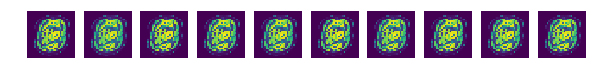

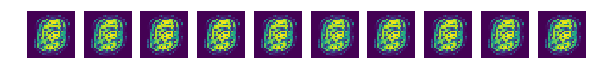

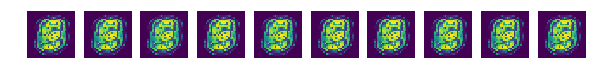

Epoch: 0001 D loss: -0.1624 G loss: -2.988
Epoch: 0002 D loss: -0.162 G loss: -2.676
Epoch: 0003 D loss: -0.665 G loss: -1.864
Epoch: 0004 D loss: -0.5878 G loss: -1.45
Epoch: 0005 D loss: -0.4243 G loss: -1.99
Epoch: 0006 D loss: -0.3996 G loss: -2.119
Epoch: 0007 D loss: -0.338 G loss: -2.628
Epoch: 0008 D loss: -0.2562 G loss: -2.585
Epoch: 0009 D loss: -0.2285 G loss: -2.805


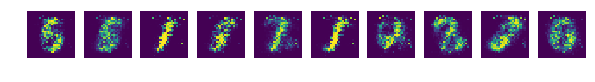

Epoch: 0010 D loss: -0.4238 G loss: -2.215
Epoch: 0011 D loss: -0.3484 G loss: -2.298
Epoch: 0012 D loss: -0.3441 G loss: -2.44
Epoch: 0013 D loss: -0.3307 G loss: -2.33
Epoch: 0014 D loss: -0.4039 G loss: -2.347
Epoch: 0015 D loss: -0.4997 G loss: -2.269
Epoch: 0016 D loss: -0.4262 G loss: -2.409
Epoch: 0017 D loss: -0.5007 G loss: -2.413
Epoch: 0018 D loss: -0.3731 G loss: -2.667
Epoch: 0019 D loss: -0.4293 G loss: -2.51


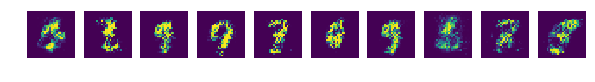

Epoch: 0020 D loss: -0.3992 G loss: -2.665
Epoch: 0021 D loss: -0.4939 G loss: -2.353
Epoch: 0022 D loss: -0.5939 G loss: -2.342
Epoch: 0023 D loss: -0.421 G loss: -2.368
Epoch: 0024 D loss: -0.3483 G loss: -2.335
Epoch: 0025 D loss: -0.5162 G loss: -2.398
Epoch: 0026 D loss: -0.5378 G loss: -2.37
Epoch: 0027 D loss: -0.488 G loss: -2.63
Epoch: 0028 D loss: -0.3457 G loss: -2.824
Epoch: 0029 D loss: -0.4252 G loss: -2.677


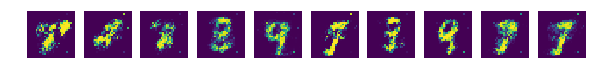

Epoch: 0030 D loss: -0.4934 G loss: -2.717
Epoch: 0031 D loss: -0.3932 G loss: -2.595
Epoch: 0032 D loss: -0.501 G loss: -2.26
Epoch: 0033 D loss: -0.4305 G loss: -2.636
Epoch: 0034 D loss: -0.3684 G loss: -2.861
Epoch: 0035 D loss: -0.4962 G loss: -2.504
Epoch: 0036 D loss: -0.5069 G loss: -2.53
Epoch: 0037 D loss: -0.5285 G loss: -2.288
Epoch: 0038 D loss: -0.5051 G loss: -2.532
Epoch: 0039 D loss: -0.4912 G loss: -2.485


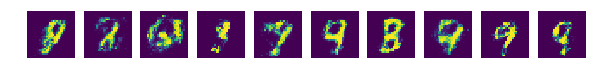

Epoch: 0040 D loss: -0.5656 G loss: -2.419
Epoch: 0041 D loss: -0.5003 G loss: -2.309
Epoch: 0042 D loss: -0.5421 G loss: -2.336
Epoch: 0043 D loss: -0.6769 G loss: -1.886
Epoch: 0044 D loss: -0.5147 G loss: -2.443
Epoch: 0045 D loss: -0.6837 G loss: -2.288
Epoch: 0046 D loss: -0.5692 G loss: -2.474
Epoch: 0047 D loss: -0.5858 G loss: -2.125
Epoch: 0048 D loss: -0.5594 G loss: -2.44
Epoch: 0049 D loss: -0.6648 G loss: -2.125


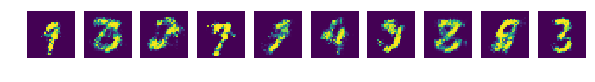

Epoch: 0050 D loss: -0.5541 G loss: -2.464
Epoch: 0051 D loss: -0.7075 G loss: -2.334
Epoch: 0052 D loss: -0.6138 G loss: -2.443
Epoch: 0053 D loss: -0.8156 G loss: -2.15
Epoch: 0054 D loss: -0.5508 G loss: -2.292
Epoch: 0055 D loss: -0.5877 G loss: -2.203
Epoch: 0056 D loss: -0.7238 G loss: -2.506
Epoch: 0057 D loss: -0.8689 G loss: -1.846
Epoch: 0058 D loss: -0.6369 G loss: -2.164
Epoch: 0059 D loss: -0.7167 G loss: -1.984


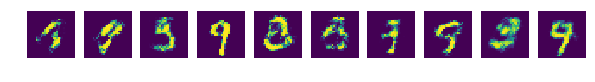

Epoch: 0060 D loss: -0.5811 G loss: -2.098
Epoch: 0061 D loss: -0.7471 G loss: -1.911
Epoch: 0062 D loss: -0.7351 G loss: -1.973


KeyboardInterrupt: 

In [10]:
#########
# 신경망 모델 학습
######
sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(mnist.train.num_examples/batch_size)
loss_val_D, loss_val_G = 0, 0

for epoch in range(total_epoch):
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        noise = get_noise(batch_size, n_noise)

        # 판별기와 생성기 신경망을 각각 학습시킵니다.
        _, loss_val_D = sess.run([train_D, loss_D],
                                 feed_dict={X: batch_xs, Z: noise})
        _, loss_val_G = sess.run([train_G, loss_G],
                                 feed_dict={Z: noise})

    print('Epoch:', '%04d' % epoch,
          'D loss: {:.4}'.format(loss_val_D),
          'G loss: {:.4}'.format(loss_val_G))

    #########
    # 학습이 되어가는 모습을 보기 위해 주기적으로 이미지를 생성하여 저장
    ######
    if epoch == 0 or (epoch + 1) % 10 == 0:
        sample_size = 10
        noise = get_noise(sample_size, n_noise)
        samples = sess.run(G, feed_dict={Z: noise})

        fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1))

        for i in range(sample_size):
            ax[i].set_axis_off()
            ax[i].imshow(np.reshape(samples[i], (28, 28)))

        #plt.savefig('samples/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
        plt.show()
        plt.close(fig)

print('최적화 완료!')
